In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import glob
import os
from os import *
import re
import imutils
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage
import collections
from ipynb.fs.full.Track_Functions import *

In [2]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [atoi(c) for c in re.split('(\d+)', text)]


In [3]:
def get_time_point(path, time_point_1):   # time_point in form of 'Take #1 ' (remember the space between #1 ') or 'Take #32'

    image_time_point_1 = []
    

    for dirname, dirnames,filenames in os.walk(path):



        for filename in sorted(filenames, key = natural_keys):



            if time_point_1 in filename:
                
                im1 = cv2.imread(os.path.join(dirname, filename))
                if np.count_nonzero(im1 == 255) < 177770000:
                    image_time_point_1.append(im1)
                
            
            

    return image_time_point_1

In [36]:
def find_and_cut(path_img,time_point_1,save_path):

    #img_list_1, img_list_2, img_list_3 = get_time_point(path_img,time_point_1,time_point_2,time_point_3)
    img_list_1 = get_time_point(path_img,time_point_1)
    
    list_img = []
    list_img.append(img_list_1)
    #list_img.append(img_list_2)
    #list_img.append(img_list_3)
    
    wells = [time_point_1] 
    
    crop_count = []

    for list_ix, _ in enumerate(list_img):

        t = []
        t = list_img[list_ix]


        dict_cord = {}
        cor = []
        x = []
        y = []
        for i in t:
            cor_0,x0,y0 = return_cord(i)
            cor.append(cor_0)
            x.append(x0)
            y.append(y0)

            data={'X':x, 'Y':y, 'Cor':cor}
            data = pd.DataFrame(data)


        dict_cord = data
        coords = dict_cord.values.tolist()

        id_cell_pr = get_id_prime(coords[0][0],coords[0][1])


        rows_1_2, cols_1_2, list_id_index_1_2 ,d_1_2 = eucl_dist_matrix_t1(coords[0][2], coords[1][2])

        try:
            index, duplicate_columns = find_duplicates_col_t1(rows_1_2, cols_1_2, list_id_index_1_2, d_1_2)

            x_1, y_1, new_cor_1, id_cell_new = remove_duplicates_t1(coords[1][0],coords[1][1], index, id_cell_pr)

            new_coor = {'Cor_1':new_cor_1}

            new_id = {'ID_1':id_cell_new}

            for ix in range(len(t)):

                row, col, list_id_index1 ,d1 = eucl_dist_matrix_t1(list(new_coor.values())[ix], coords[2+ix][2])

                row1, col1 = zip(*list_id_index1)


                # Index duplicates cols


                duplicates2 = []
                for item in col1:
                    if col1.count(item) > 1:
                        duplicates2.append(item)
                dup_set2 = set(duplicates2)


                # Index unused cols

                r = len(list(new_coor.values())[ix])
                unused_col = list(range(0, r))
                unused = set(col1)
                idx_unused_col = [x for x in unused_col if x not in unused]


                n_cord_new, id_cell_new = final_fun(dup_set2, idx_unused_col, d1, list(new_id.values())[ix], list_id_index1, coords[2+ix][2], list(new_coor.values())[ix])

                new_coor['Cor_{}'.format(2+ix)] = n_cord_new
                new_id['ID_{}'.format(2+ix)] = id_cell_new


        except IndexError:
            pass


        del t[0]

        coor = []
        id_c = []

        for k, v in new_coor.items():
            coor.append(v)

        for p, c in new_id.items():
            id_c.append(c)

        for idx , _ in enumerate(t):

            img = t[idx]

            crop_cell_1 = []

            x = []
            y = []

            for ix, i in enumerate(coor[idx]):
                x.append(coor[idx][ix][0])      
                y.append(coor[idx][ix][1])


            w = 45
            h = 45

            try_id = []

            for ix, i in enumerate(x):

                s = id_c[idx][ix]


                crop = img[(y[ix]-h):(y[ix]+h), (x[ix]-w):(x[ix]+w)]

                if crop.size == 24300: 

                    crop_cell_1.append(crop) 
                    try_id.append(s)

            for ls, i in enumerate(crop_cell_1):

                im = Image.fromarray(i)

                im.save(save_path.format(via, wells[list_ix],try_id[ls], int(idx+1)))  
                
            crop_count.append(len(crop_cell_1))
            
    return sum(crop_count)


In [37]:
list_directory = []
for i in glob.glob('/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/*'):
    list_directory.append(i.split('_')[-1])

In [38]:
list_directory

['CONTROLL',
 'METHOXAMINE',
 'MIDORINE',
 'LEBETALOL',
 'MEPHENTEREMINE',
 'OXYMETAZOLINE',
 'CYCLIZINE',
 'DOXYLAMINE',
 'OLOPATADINE',
 'KETOFINE',
 'ORPHENADRINE']

In [39]:
for l_name_well in tqdm.tqdm(list_directory):

    p = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/full_size_{}/'.format(l_name_well)

    name_well = []
    for di,dr,f in os.walk(p):
        for i in f:
            name_well.append(i.split(' ')[1].split(' ')[0])

    wells = list(set(name_well))

    via = '/home/jovyan/DATA_MASTER_PROJECT/Check_DIFF_T60_T_97/{}_cropped/'.format(l_name_well)
    directory = os.mkdir(via) 



    final_count = []

    for i in wells:

        count = find_and_cut(p , i , '{0}/{1}_id_{2}_time_{3}.tiff')

        final_count.append(count)




  0%|          | 0/11 [00:00<?, ?it/s]


  9%|▉         | 1/11 [04:21<43:32, 261.24s/it]


 18%|█▊        | 2/11 [07:46<36:40, 244.49s/it]


 27%|██▋       | 3/11 [11:48<32:29, 243.72s/it]


 36%|███▋      | 4/11 [14:43<26:00, 222.95s/it]


 45%|████▌     | 5/11 [17:42<21:00, 210.01s/it]


 55%|█████▍    | 6/11 [20:38<16:39, 199.84s/it]


 64%|██████▎   | 7/11 [23:46<13:04, 196.25s/it]


 73%|███████▎  | 8/11 [26:55<09:42, 194.03s/it]


 82%|████████▏ | 9/11 [30:56<06:55, 207.99s/it]


 91%|█████████ | 10/11 [34:34<03:31, 211.10s/it]


100%|██████████| 11/11 [38:08<00:00, 208.08s/it]


In [15]:
img = []
for i in glob.glob(via + '/' + '*.tiff'):
    if 'B3-4_id_5_' in i:
        im = cv2.imread(i)
        img.append(im)
        


In [16]:
len(img)

30

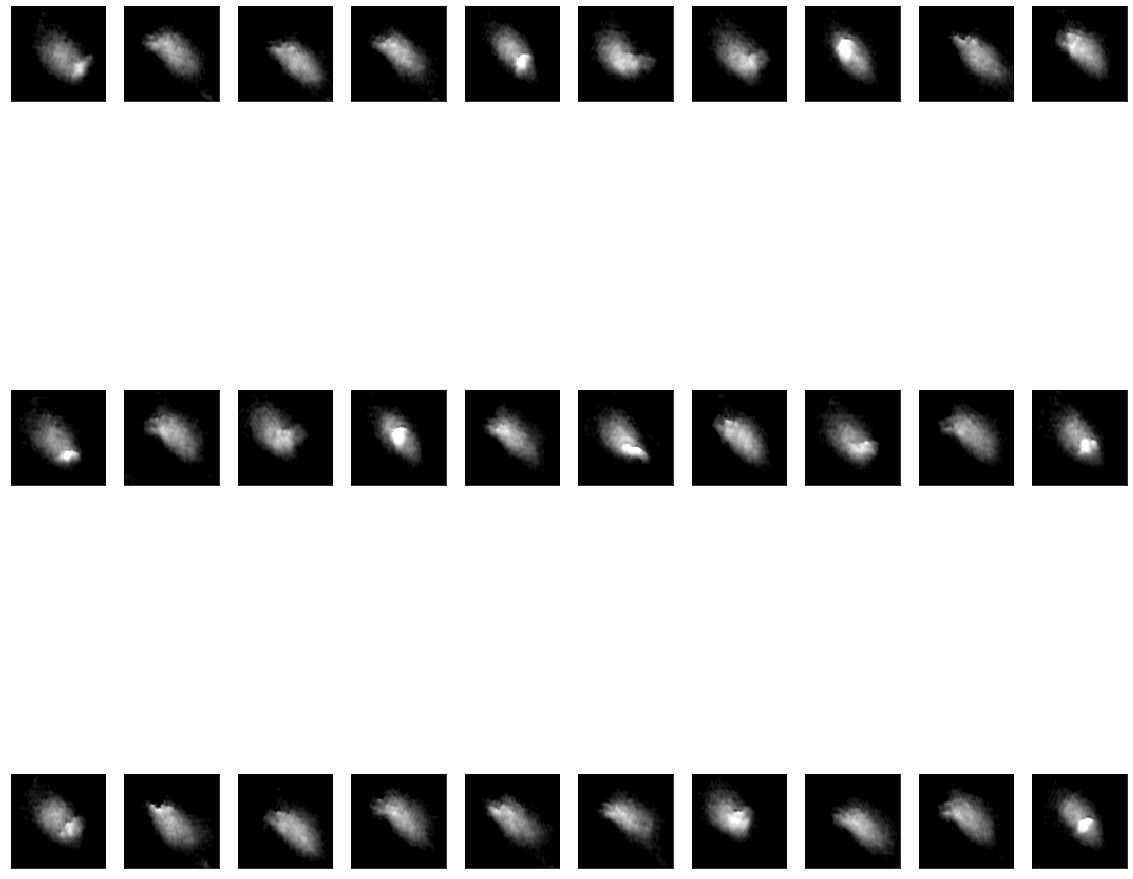

In [17]:
fig = plt.figure(figsize=(20, 20))


for i in range(30):
    ax = fig.add_subplot(3,10,i+1),plt.imshow(img[i],'gray')
    #plt.title(titles[i], color='white')
    plt.xticks([]),plt.yticks([])
plt.show()